# Diabetes EDA

## Import libraries

In [142]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

df = pd.read_csv("/home/mustafa/PycharmProjects/diabetes_pred/diabetes.csv")



### 1- Exploratory Data Analysis (EDA)

#### check_df is a function that I wrote to get a quick overview of the data set.

In [143]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("\n##################### Info #####################")
    print(dataframe.info())
    print("\n##################### Types #####################")
    print(dataframe.dtypes)
    print("\n##################### Head #####################")
    print(dataframe.head(head))
    print("\n##################### Tail #####################")
    print(dataframe.tail(head))
    print("\n################ Null Values ##################")
    print(dataframe.isnull().values.any())
    print("\n##################### NA #####################")
    print(dataframe.isnull().sum())
    print("\n##################### Not in 0 for NA #####################")
    print(df.isnull().sum()[df.isnull().sum() != 0])
    print("\n##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("\n##################### Value Counts #####################")
    print([df[col].value_counts() for col in df.columns if df[col].nunique() < 10])

check_df(df)

##################### Shape #####################
(768, 9)

##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

##################### Types #####################
Pregnancies                   int64
Glucose                       int64
Blo

Pregnancies: Number of pregnancies
Glucose: Expressing the Glucose level in the blood
BloodPressure: Blood pressure (Diastolic)
SkinThickness: Skin Thickness
Insulin: Insulin level in the blood
BMI: Body mass index.
DiabetesPedigreeFunction: A function that calculates our probability of having diabetes based on people in our ancestry.
Age: Age (years)
Outcome: Information about whether the person has diabetes or not. Having the disease (1) or not (0)

- All variables are numeric. 
- The target variable is "Outcome"
- There are no missing values.
- No Null Values
- Minimum value of many values, etc. Values such as appear as 0. It is not possible for a person's values such as glucose, insulin, blood pressure to be zero. Most likely, missing values in the data are filled with zeros.

#### Capture Numerical and Categorical Variables

In [144]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
     It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
     Note: Categorical variables with numerical appearance are also included.

     parameters
     ------
         dataframe: dataframe
                 Dataframe from which variable names are to be taken
         cat_th: int, optional
                 Class threshold value for variables that are numeric but categorical
         car_th: int, optional
                 class threshold for categorical but cardinal variables

     returns
     ------
         cat_cols: list
                 Categorical variable list
         num_cols: list
                 Numerical variable list
         cat_but_car: list
                 List of cardinal variables with categorical view

     examples
     ------
         import seaborn as sns
         df = sns.load_dataset("iris")
         print(grab_col_names(df))


     Notes
     ------
         cat_cols + num_cols + cat_but_car = total number of variables
         num_but_cat is inside cat_cols.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int64", "float64", "int32", "float32"]]

    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64", "int32", "float32"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}\nVariables: {dataframe.shape[1]}\ncat_cols: {len(cat_cols)}\n"
          f"num_cols: {len(num_cols)}\ncat_but_car: {len(cat_but_car)}\nnum_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
print(f"\ncat_cols: {cat_cols}\nnum_cols: {num_cols}\ncat_but_car: {cat_but_car}")

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1

cat_cols: ['Outcome']
num_cols: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
cat_but_car: []


#### Analysis with Categorical Variables

In [145]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
        
cat_summary(df, "Outcome")

         Outcome      Ratio
Outcome                    
0            500  65.104167
1            268  34.895833
##########################################


#### Analysis with Numerical Variables

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64

##########################################


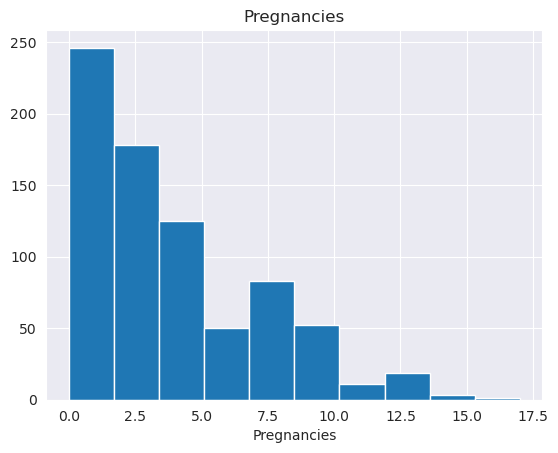

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64

##########################################


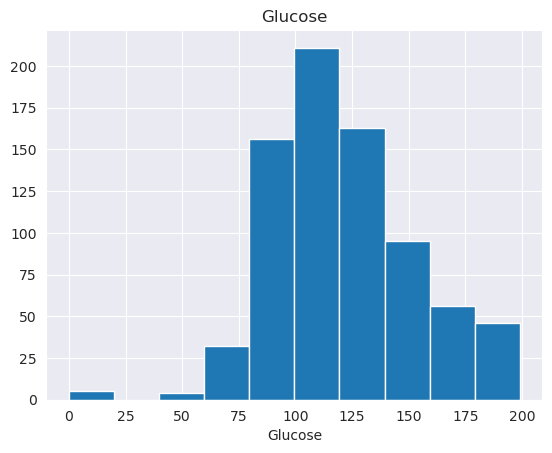

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64

##########################################


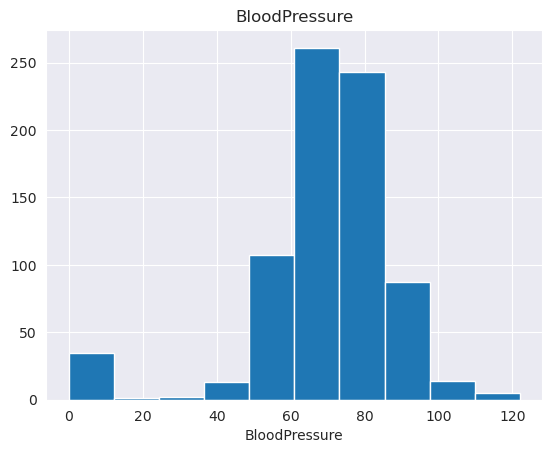

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64

##########################################


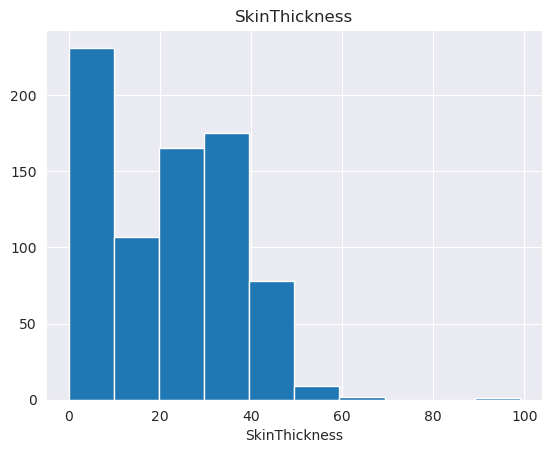

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64

##########################################


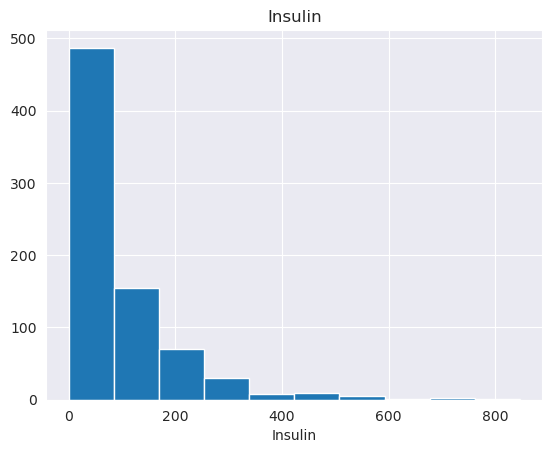

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64

##########################################


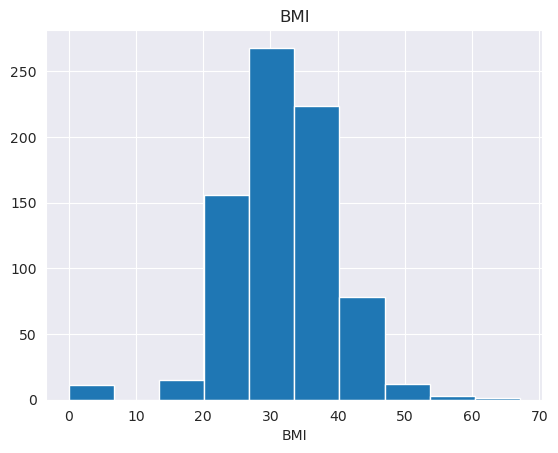

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64

##########################################


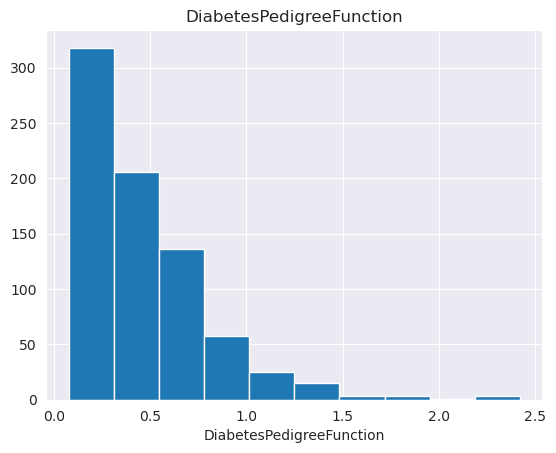

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64

##########################################


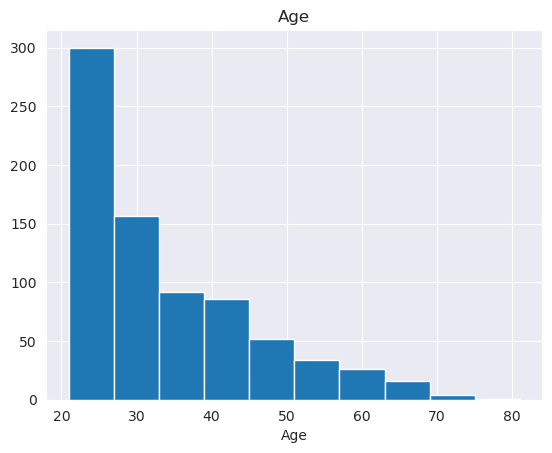

In [146]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    print("\n##########################################")
    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

- When we examine the graphs of numerical variables, we see that the value 0 is dominant in some graphs. This increases the possibility of filling missing values with zero. (BMI, Insulin, BloodPressure, Glucose, SkinThickness)

#### Analysis of Correlation

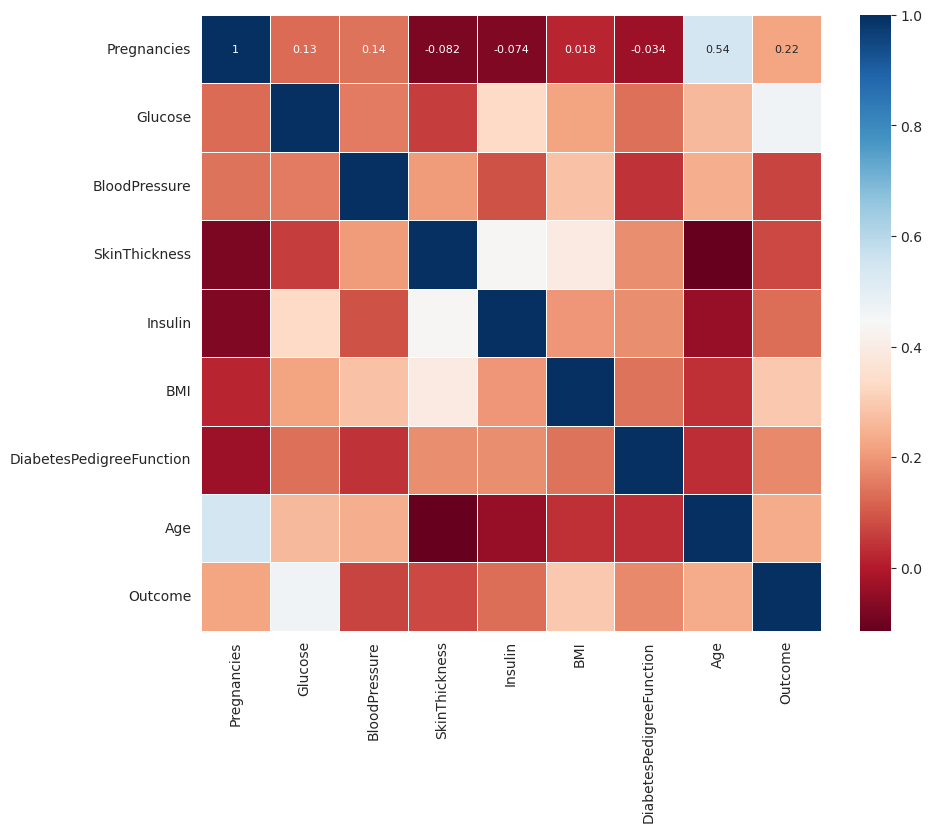

In [147]:
def correlation(df,cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 8}, linecolor='w', cmap='RdBu')
    plt.show()

correlation(df, df.columns)



- There appears to be a positive moderate relationship between age and pregnancy. We expect the number of pregnancies to increase as age increases.


#### Analysis of Target Variable with Numerical Variables

In [148]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
    
for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col)

         TARGET_MEAN
Outcome             
0                0.0
1                1.0


In [149]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164


If we examine the relationship between the target variable and numerical variables:
- The average age of people with diabetes is higher than those without diabetes.
- The average BMI of people with diabetes is higher than those without diabetes.
- Insulin and Glcucos averages are higher in people with diabetes, as expected.
- BloodPressure and SkinThickness are higher in people with diabetes, as expected.

#### Outliers

In [150]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

for col in num_cols:
    print(col,"-->", check_outlier(df, col))


Pregnancies --> True
Glucose --> True
BloodPressure --> True
SkinThickness --> True
Insulin --> True
BMI --> True
DiabetesPedigreeFunction --> True
Age --> True


### 2. Data Preprocessing & Feature Engineering

#### Missing Values Analysis
- It is known that variable values other than Pregnancies and Outcome cannot be 0 in a human.
- Therefore, an action decision should be made regarding these values. Values that are 0 can be assigned NaN.

In [151]:
"""zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

print(zero_columns)

for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

# missing values
df.isnull().sum()"""

'zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]\n\nprint(zero_columns)\n\nfor col in zero_columns:\n    df[col] = np.where(df[col] == 0, np.nan, df[col])\n\n# missing values\ndf.isnull().sum()'

In [152]:
"""def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False) 
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False) #
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)"""

'def missing_values_table(dataframe, na_name=False):\n    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]\n    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False) \n    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False) #\n    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=[\'n_miss\', \'ratio\'])\n    print(missing_df, end="\n")\n    if na_name:\n        return na_columns\n\nna_columns = missing_values_table(df, na_name=True)'

#### Missing Values Analysis with Target Variable

In [153]:
"""def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Outcome", na_columns)"""

'def missing_vs_target(dataframe, target, na_columns):\n    temp_df = dataframe.copy()\n    for col in na_columns:\n        temp_df[col + \'_NA_FLAG\'] = np.where(temp_df[col].isnull(), 1, 0)\n    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns\n    for col in na_flags:\n        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),\n                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")\n\n\nmissing_vs_target(df, "Outcome", na_columns)'

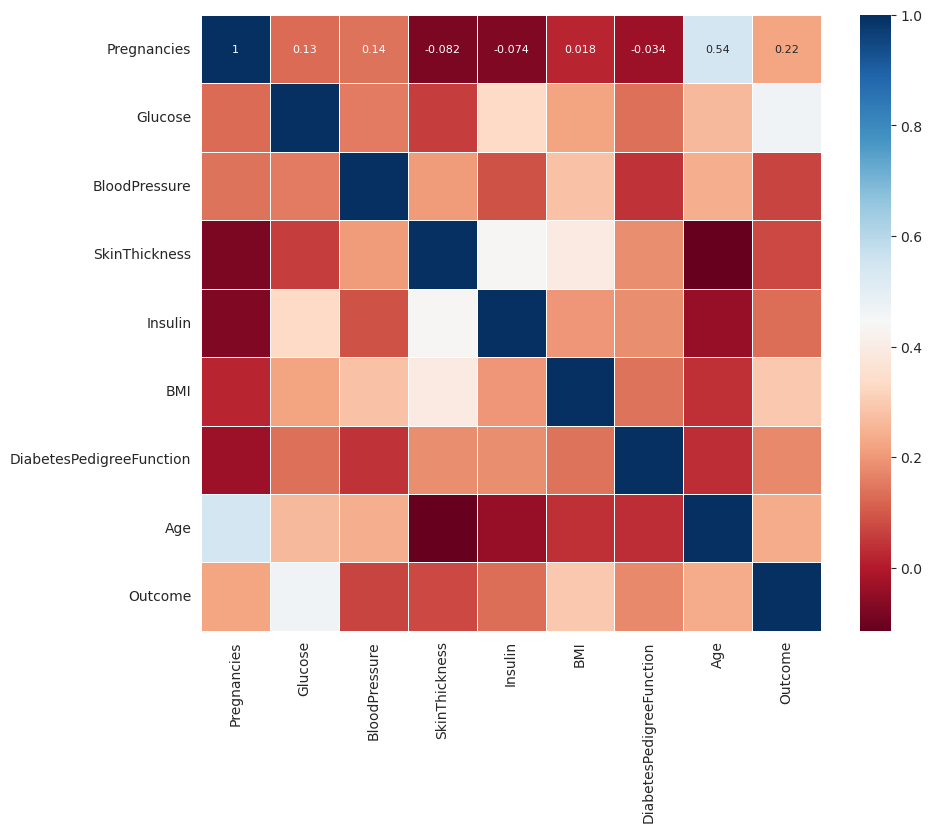

In [154]:
correlation(df, df.columns)

### Feature Extraction

In [155]:
def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Creation of new variables.
    
    # Age : Categorizing the age variable and creating a new age variable.
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'
    
    # Glucose : Convert glucose value to a categorical variable
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200, 300], labels=["normal", "prediabetes", "diabetes"])
    
    # BMI below 18.5 is underweight, between 18.5 and 24.9 is healthy, between 24.9 and 29.9 is overweight and above 30 is obese
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                 labels=["underweight", "healthy", "overweight", "obese"])
    
    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])

    # # Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma
    dataframe.loc[(dataframe['AGE'] < 35) & (dataframe['BMI'] < 18.5), "NEW_AGE_BMI_CAT"] = 'young_underweight'
    dataframe.loc[(dataframe['AGE'] < 35) & (dataframe['BMI'] >= 18.5) & (dataframe['BMI'] < 24.9), "NEW_AGE_BMI_CAT"] = 'young_healthy'
    dataframe.loc[(dataframe['AGE'] < 35) & (dataframe['BMI'] >= 24.9) & (dataframe['BMI'] < 29.9), "NEW_AGE_BMI_CAT"] = 'young_overweight'
    dataframe.loc[(dataframe['AGE'] < 35) & (dataframe['BMI'] >= 29.9), "NEW_AGE_BMI_CAT"] = 'young_obese'
    
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55) & (dataframe['BMI'] < 18.5), "NEW_AGE_BMI_CAT"] = 'middleage_underweight'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55) & (dataframe['BMI'] >= 18.5) & (dataframe['BMI'] < 24.9), "NEW_AGE_BMI_CAT"] = 'middleage_healthy'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55) & (dataframe['BMI'] >= 24.9) & (dataframe['BMI'] < 29.9), "NEW_AGE_BMI_CAT"] = 'middleage_overweight'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55) & (dataframe['BMI'] >= 29.9), "NEW_AGE_BMI_CAT"] = 'middleage_obese'
    
    dataframe.loc[(dataframe['AGE'] > 55) & (dataframe['BMI'] < 18.5), "NEW_AGE_BMI_CAT"] = 'old_underweight'
    dataframe.loc[(dataframe['AGE'] > 55) & (dataframe['BMI'] >= 18.5) & (dataframe['BMI'] < 24.9), "NEW_AGE_BMI_CAT"] = 'old_healthy'
    dataframe.loc[(dataframe['AGE'] > 55) & (dataframe['BMI'] >= 24.9) & (dataframe['BMI'] < 29.9), "NEW_AGE_BMI_CAT"] = 'old_overweight'
    dataframe.loc[(dataframe['AGE'] > 55) & (dataframe['BMI'] >= 29.9), "NEW_AGE_BMI_CAT"] = 'old_obese'
    
    # Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
    dataframe.loc[(dataframe['AGE'] < 35) & (dataframe['GLUCOSE'] < 139), "NEW_AGE_GLUCOSE_CAT"] = 'young_normal'
    dataframe.loc[(dataframe['AGE'] < 35) & (dataframe['GLUCOSE'] >= 139) & (dataframe['GLUCOSE'] < 200), "NEW_AGE_GLUCOSE_CAT"] = 'young_prediabetes'
    dataframe.loc[(dataframe['AGE'] < 35) & (dataframe['GLUCOSE'] >= 200), "NEW_AGE_GLUCOSE_CAT"] = 'young_diabetes'
    
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55) & (dataframe['GLUCOSE'] < 139), "NEW_AGE_GLUCOSE_CAT"] = 'middleage_normal'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55) & (dataframe['GLUCOSE'] >= 139) & (dataframe['GLUCOSE'] < 200), "NEW_AGE_GLUCOSE_CAT"] = 'middleage_prediabetes'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55) & (dataframe['GLUCOSE'] >= 200), "NEW_AGE_GLUCOSE_CAT"] = 'middleage_diabetes'
    
    dataframe.loc[(dataframe['AGE'] > 55) & (dataframe['GLUCOSE'] < 139), "NEW_AGE_GLUCOSE_CAT"] = 'old_normal'
    dataframe.loc[(dataframe['AGE'] > 55) & (dataframe['GLUCOSE'] >= 139) & (dataframe['GLUCOSE'] < 200), "NEW_AGE_GLUCOSE_CAT"] = 'old_prediabetes'
    dataframe.loc[(dataframe['AGE'] > 55) & (dataframe['GLUCOSE'] >= 200), "NEW_AGE_GLUCOSE_CAT"] = 'old_diabetes'
    

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)
    
    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    df.columns = [col.upper() for col in df.columns]

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

In [156]:
check_df(df)

##################### Shape #####################
(768, 9)

##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

##################### Types #####################
Pregnancies                   int64
Glucose                       int64
Blo

In [157]:
X, y = diabetes_data_prep(df)

Observations: 768
Variables: 15
cat_cols: 7
num_cols: 8
cat_but_car: 0
num_but_cat: 1
Observations: 768
Variables: 34
cat_cols: 26
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [158]:
check_df(X)

##################### Shape #####################
(768, 33)

##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   PREGNANCIES                                768 non-null    float64
 1   GLUCOSE                                    768 non-null    float64
 2   BLOODPRESSURE                              768 non-null    float64
 3   SKINTHICKNESS                              768 non-null    float64
 4   INSULIN                                    768 non-null    float64
 5   BMI                                        768 non-null    float64
 6   DIABETESPEDIGREEFUNCTION                   768 non-null    float64
 7   AGE                                        768 non-null    float64
 8   NEW_AGE_CAT_OLD                            768 non-null    b

### 3. Model Building

In [159]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier(verbose=-1)),
                   ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.7435 (XGBoost) 
accuracy: 0.7422 (LightGBM) 
accuracy: 0.7734 (CatBoost) 


### 4. Automated Hyperparameter Optimization

In [160]:

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1]}


classifiers = [('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(verbose=-1), lightgbm_params),
               ('CatBoost', CatBoostClassifier(verbose=False), catboost_params)]  

def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## XGBoost ##########
roc_auc (Before): 0.8042
roc_auc (After): 0.818
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
roc_auc (Before): 0.8027
roc_auc (After): 0.8183
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}

########## CatBoost ##########
roc_auc (Before): 0.8364
roc_auc (After): 0.8381
CatBoost best params: {'iterations': 500, 'learning_rate': 0.01}


In [161]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('XGBoost', best_models["XGBoost"]),
                                              ('LightGBM', best_models["LightGBM"]),
                                              ('CatBoost', best_models["CatBoost"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...
Accuracy: 0.7721354166666666
F1Score: 0.6546764846378396
ROC_AUC: 0.8296285488076537


In [184]:
X.columns
random_user = X.sample(1, random_state=45)
voting_clf.predict(random_user)

joblib.dump(voting_clf, "voting_clf2.pkl")

new_model = joblib.load("voting_clf2.pkl")
new_model.predict(random_user)


array([1])

In [164]:
df = pd.read_csv("/home/mustafa/PycharmProjects/diabetes_pred/diabetes.csv")
X, y = diabetes_data_prep(df)
base_models(X, y)
best_models = hyperparameter_optimization(X, y)
voting_clf = voting_classifier(best_models, X, y)
joblib.dump(voting_clf, "voting_clf.pkl")


Observations: 768
Variables: 15
cat_cols: 7
num_cols: 8
cat_but_car: 0
num_but_cat: 1
Observations: 768
Variables: 34
cat_cols: 26
num_cols: 8
cat_but_car: 0
num_but_cat: 1
Base Models....
roc_auc: 0.8042 (XGBoost) 
roc_auc: 0.8027 (LightGBM) 
roc_auc: 0.8364 (CatBoost) 
Hyperparameter Optimization....
########## XGBoost ##########
roc_auc (Before): 0.818
roc_auc (After): 0.818
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
roc_auc (Before): 0.8183
roc_auc (After): 0.8183
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}

########## CatBoost ##########
roc_auc (Before): 0.8381
roc_auc (After): 0.8381
CatBoost best params: {'iterations': 500, 'learning_rate': 0.01}

Voting Classifier...
Accuracy: 0.7721354166666666
F1Score: 0.6546764846378396
ROC_AUC: 0.8296285488076537


['voting_clf.pkl']

In [182]:

random_user = X.sample(1, random_state=1)

voting_clf.predict(random_user)


array([0])